## Imports

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.signal import medfilt
from scipy.optimize import curve_fit

import warnings

## Data Loading

In [70]:
# --- Data Loading ---

def lpr_cor_import(filename):
    """ Import cor file as pandas dataframe."""

    try: 
        df = pd.read_csv(
            filename,
            skiprows=26,
            sep='\s+',
            header=None,
            names=["E", "i", "T"],
        ) 
        df.drop(columns=["T"], inplace=True)
        df["E"] = df["E"]*1e3 # Convert it to mV
        
    except FileNotFoundError as e:
        print(f"Error: File was not found.")
        print(e.message)
        print(e.args)
        return None
    except Exception as e:
        print(f"Error reading the CSV file: {e}")
        return None   
    else:
        return df

In [71]:
HS1_1 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_1.cor")
HS1_2 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_2.cor")
HS1_3 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_3.cor")
HS1_4 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_4.cor")
HS1_5 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_5.cor")
HS1_6 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_6.cor")

# Keep it in the same cell to keep df reproducible, even if Vi clicks it multiple times
area = 2 #cm^2

for df in [HS1_1, HS1_2, HS1_3, HS1_4, HS1_5, HS1_6]:
    df["i"] = np.abs(df["i"]/area) # Current density


In [72]:
HS1_1 

E             i
0    -206.795  7.859750e-11
1    -206.805  5.445100e-11
2    -206.809  6.106750e-11
3    -206.795  5.972600e-11
4    -206.780  5.621750e-11
...       ...           ...
3999 -166.870  7.752900e-11
4000 -166.854  7.931000e-11
4001 -166.857  7.781400e-11
4002 -166.850  7.296700e-11
4003 -166.846  6.987300e-11

[4004 rows x 2 columns]

# Coding part!

Separate code into analyze and plotting, with all answers in a dict.
Can't believe it took me this long to really do it this way :|

Anodic    n =  b_a*log(i/i_a) b_a = 5.08 mV/decade i_a = 5.21e-12 A/cm2
Cathodic  n = -b_c*log(i/i_c) b_c = 6.96 mV/decade i_c = 4.18e-12 A/cm2


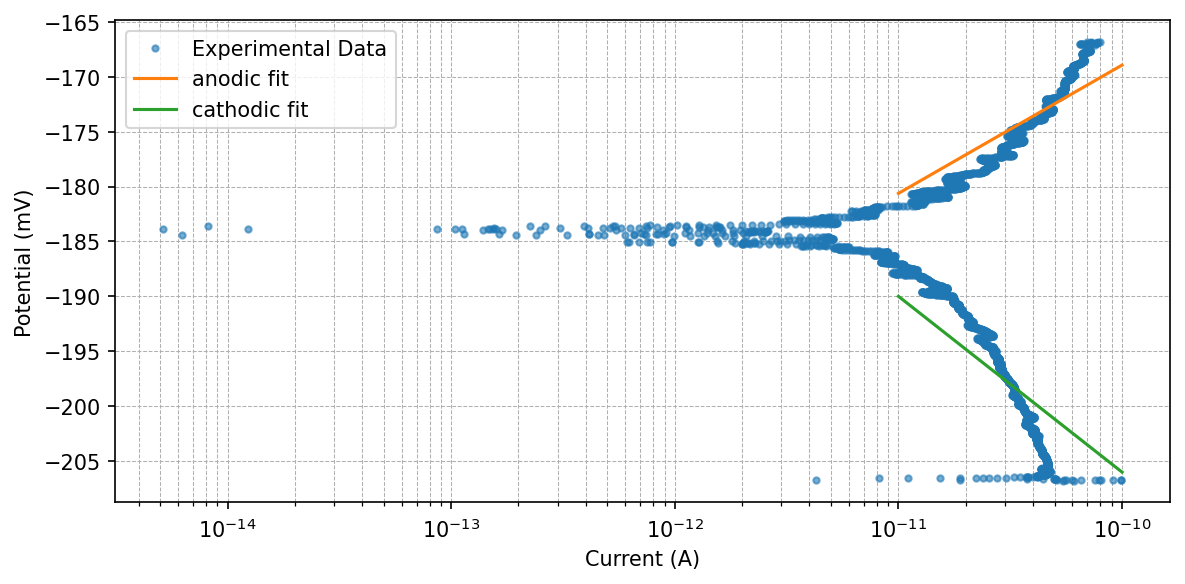

In [231]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
data = HS1_1

INITIAL_KERNEL = 29
FIT_KERNEL = 99

# Plot the raw experimental data
ax.semilogx(np.abs(data["i"].to_numpy()), data["E"].to_numpy(),
            marker='o', linestyle='', markersize=3, alpha=0.6, label="Experimental Data")

# 1. Estimate Corrosion Potential (Ecorr) using a median filter
ecorr_guess = data['E'].iloc[np.argmin(medfilt(data['i'], kernel_size=INITIAL_KERNEL))]

# 2. Split data into anodic and cathodic regions based on Ecorr
anodic_data = data[data['E'] > ecorr_guess]
cathodic_data = data[data['E'] < ecorr_guess]

# 3. Perform curve fit on E vs. i for each branch
medfilt_anodic_i = medfilt(anodic_data['i'].iloc[30:-30], kernel_size=FIT_KERNEL)
medfilt_cathodic_i = medfilt(cathodic_data['i'].iloc[30:-30], kernel_size=FIT_KERNEL)

def log_func(i, b, i_0):
    with np.errstate(divide='ignore', invalid='ignore'):
        result = b * np.log(np.abs(i)/i_0)
    return np.nan_to_num(result, nan=np.inf)

max_calls = 50000
popt_anodic, _ = curve_fit(log_func, 
                           medfilt(anodic_data['i'].iloc[30:-30], kernel_size=FIT_KERNEL),
                           anodic_data['E'].iloc[30:-30]  - ecorr_guess,
                           p0=[0.05*1e3, 1e-11],
                           maxfev=max_calls)
popt_cathodic, _ = curve_fit(log_func, 
                             medfilt(cathodic_data['i'].iloc[30:-30], kernel_size=FIT_KERNEL),
                             cathodic_data['E'].iloc[30:-30] - ecorr_guess,
                             p0=[-0.05*1e3, 1e-11],                               
                             maxfev=max_calls)
beta_a = popt_anodic[0]
beta_c = -popt_cathodic[0]
i_a = popt_anodic[1]
i_c = popt_cathodic[1]

print(f"Anodic    n =  b_a*log(i/i_a) b_a = {beta_a:.2f} mV/decade i_a = {i_a:.2e} A/cm2")
print(f"Cathodic  n = -b_c*log(i/i_c) b_c = {beta_c:.2f} mV/decade i_c = {i_c:.2e} A/cm2")

p_anodic = lambda x: log_func(x, *popt_anodic) + ecorr_guess
p_cathodic = lambda x: log_func(x, *popt_cathodic) + ecorr_guess

ax.semilogx(np.logspace(-10,-11, 100), p_anodic(np.logspace(-10,-11, 100)), label="anodic fit")
ax.semilogx(np.logspace(-10,-11, 100), p_cathodic(np.logspace(-10,-11, 100)), label="cathodic fit")

# Configure plot aesthetics
ax.set_xlabel("Current (A)")
ax.set_ylabel("Potential (mV)")
ax.legend()
ax.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()



## Analyze Tafel Data

In [232]:


def analyze_tafel_data(
    data: pd.DataFrame
) -> dict | None:

    INITIAL_KERNEL = 29
    FIT_KERNEL = 99
    
    # 1. Estimate Corrosion Potential (Ecorr) using a median filter
    ecorr_guess = data['E'].iloc[np.argmin(medfilt(data['i'], kernel_size=INITIAL_KERNEL))]

    # 2. Split data into anodic and cathodic regions based on Ecorr
    anodic_data = data[data['E'] > ecorr_guess]
    cathodic_data = data[data['E'] < ecorr_guess]
    if anodic_data.empty or cathodic_data.empty:
        warnings.warn("No data in anodic or cathodic regions?. Ecorr guess may be incorrect.")    

    # 3. Perform linear fit on E vs. i for each branch
    medfilt_anodic_i = medfilt(anodic_data['i'].iloc[30:-30], kernel_size=FIT_KERNEL)
    p_anodic = np.poly1d(np.polyfit(medfilt_anodic_i, anodic_data['E'].iloc[30:-30], 1))
    medfilt_cathodic_i = medfilt(cathodic_data['i'].iloc[30:-30], kernel_size=FIT_KERNEL)
    p_cathodic = np.poly1d(np.polyfit(medfilt_cathodic_i, cathodic_data['E'].iloc[30:-30], 1))

    # 4. Calculate the tangent at the extreme ends of the filtered data
    i_extreme_anodic = medfilt_anodic_i.max()
    e_extreme_anodic = p_anodic(i_extreme_anodic)
    tangent_slope_anodic = p_anodic.coeffs[0] * (i_extreme_anodic * np.log(10))

    i_extreme_cathodic = medfilt_cathodic_i.max()
    e_extreme_cathodic = p_cathodic(i_extreme_cathodic)
    tangent_slope_cathodic = p_cathodic.coeffs[0] * (i_extreme_cathodic * np.log(10))
   
    # 5. Calculate tangent lines    
    log_i_extreme_anodic = np.log10(i_extreme_anodic)
    log_i_tangent_anodic = np.linspace(log_i_extreme_anodic - 0.5, log_i_extreme_anodic, 100)
    e_tangent_anodic = (
        tangent_slope_anodic * (log_i_tangent_anodic - log_i_extreme_anodic)
        + e_extreme_anodic
    )

    log_i_extreme_cathodic = np.log10(i_extreme_cathodic)
    log_i_tangent_cathodic = np.linspace(log_i_extreme_cathodic - 0.5, log_i_extreme_cathodic, 100)
    e_tangent_cathodic = (
        tangent_slope_cathodic * (log_i_tangent_cathodic - log_i_extreme_cathodic)
        + e_extreme_cathodic
    )


    # --- 3. Calculations ---
    temp_kelvin = 25.0 + 273.15
    R = 8.314  # Ideal Gas Constant (J/(mol·K))
    F = 96485  # Faraday Constant (C/mol)
    n = 2 # Number of electrons transferred in your electrochemical reaction.    
    
    # Calculate the anodic charge transfer coefficient (alpha_a)
    # This value represents the fraction of the potential that assists the oxidation reaction.
    try:
        alpha_a = (2.303 * R * temp_kelvin) / (1000 * tangent_slope_anodic * n * F)
        alpha_c = -(2.303 * R * temp_kelvin) / (1000 * tangent_slope_cathodic * n * F)    
    except ZeroDivisionError as e:
        print("Slope is zero, what happened?")
        print(e)
  
    
    # 6. Package results into a dictionary
    results = {
        "ecorr_guess": ecorr_guess,
        "beta_a": tangent_slope_anodic,        
        "beta_c": tangent_slope_cathodic,
        "anodic_tangent_i": 10**log_i_tangent_anodic,
        "anodic_tangent_E": e_tangent_anodic,
        "cathodic_tangent_i": 10**log_i_tangent_cathodic,
        "cathodic_tangent_E": e_tangent_cathodic,
        
    }
    return results

## Plotting code

Plot the additional stuff only if you have results.
Use the same function for everything
Again, why didn't I do this earlier :|


In [233]:
def plot_tafel(data: pd.DataFrame, results: dict):
    """
    Generates and displays a Tafel plot from the data and analysis results.

    Args:
        data (pd.DataFrame): The original experimental data.
        results (dict): The dictionary returned by analyze_tafel_data.
    """
    fig, ax = plt.subplots(figsize=(8, 4), dpi=150)

    # Plot the raw experimental data
    ax.semilogx(
        np.abs(data["i"].to_numpy()), data["E"].to_numpy(),
        marker='o', linestyle='', markersize=3, alpha=0.6, label="Experimental Data"
    )

    # Plot the analysis results if available
    if results:
        
        ax.axhline(  # Ecorr line
            y=results["ecorr_guess"],
            color='green', linestyle='--', linewidth=2,
            label=f'$E_{{corr}}$ = {results["ecorr_guess"]:.2f} mV'
        )
        
        ax.plot(     # Anodic tangent line
            results["anodic_tangent_i"], results["anodic_tangent_E"],
            color='red', linestyle='-.', linewidth=2,
            label=f'Anodic Tangent {results["beta_a"]:.2f}'
        )
        
        ax.plot(     # Cathodic tangent line
            results["cathodic_tangent_i"], results["cathodic_tangent_E"],
            color='blue', linestyle='-.', linewidth=2,
            label=f'Cathodic Tangent {results["beta_c"]:.2f}'
        )

        bx = ax.twinx()  
        ymin, ymax = ax.get_ylim()
        bx.set_ylim(ymin-results["ecorr_guess"], ymax-results["ecorr_guess"])
        bx.set_ylabel("Overpotential (mV)")
    
    # Configure plot aesthetics
    ax.set_xlabel("Current (A)")
    ax.set_ylabel("Potential (mV)")
    ax.legend()
    ax.grid(True, which="both", ls="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()


# Funspace

alpha_a 38.63008297021084
alpha_c -53.89894810425625


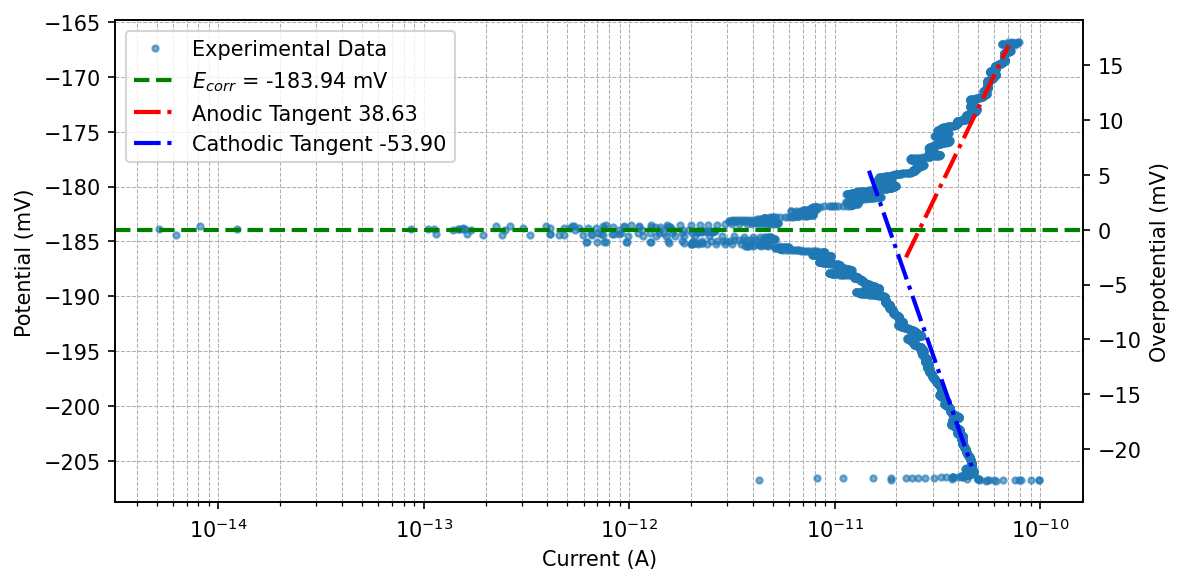

In [235]:
# =============================================================================
# --- Main Execution Block ---
# =============================================================================

# 1. Analyze the dataset
analysis_results = analyze_tafel_data(HS1_1)
print(f"alpha_a {analysis_results['beta_a']}")
print(f"alpha_c {analysis_results['beta_c']}")


# 2. Plot the results
if analysis_results:
    plot_tafel(HS1_1, analysis_results)
else:
    print("Analysis could not be completed.")

#print(analysis_results)